# LAPD lab - Machine learning project

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

## Environnement and dataset definition

### Libraries

First, we import all important packages, data, and set the seed (for torch).


In [ ]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import sys
import itertools

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

### Mounting the drive
You may need to adjust the path according to your needs.

In [ ]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
#path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
#path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)
import sys
# Append the directory to your python path using sys
sys.path.append(path)
# Import the module
print("importing helper_functions")
#import helper_functions_py
from helper_functions_py import *

Mounted at /content/drive
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy
model.pt
meteo_summary.xlsx
median_Q1_Q3.xlsx
labels_only_meteo.xlsx
meteo_data_only.xlsx
iraddiance_raw.xlsx
meteo_time_raw.xlsx
__pycache__
Project_meteo_only.ipynb
helper_functions_py.py
Preprocessing_meteo_only.ipynb
importing helper_functions


### Creation of the Dataset

This class allows us to load the dataset and access each element individually.

#### GHIDataset

This dataset allows to retrieve multiple indices at once, hence allowing to load consecutive samples.

In [ ]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, meteo, GHI, mean_std,  transform_label=0, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """

        self.root_dir = root_dir

        # Define the transforms to apply to labels or input
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo
        self.GHI_path = GHI
        self.meteo = meteo

        # Load mean and std values from mean_std Excel file
        mean_std_df = pd.read_excel(os.path.join(self.root_dir, mean_std))
        self.mean_std_dict = dict(zip(mean_std_df['Column'], zip(mean_std_df['Mean'], mean_std_df['Std'])))

        df1 = pd.read_excel(os.path.join(self.root_dir, self.meteo))
        # Drop useless columns
        df1 = df1.drop(['Unnamed: 0', 'stn', 'time', 'Date', 'Time'], axis=1)

        # Read the second dataframe
        df2 = pd.read_excel(os.path.join(self.root_dir, self.GHI_path))

        # Sort dataframes based on timestamps
        df1 = df1.sort_values('Real_time_CH')
        df2 = df2.sort_values('Time')

        # Convert timestamps to datetime objects
        df1['Real_time_CH'] = pd.to_datetime(df1['Real_time_CH'])
        df2['Time']         = pd.to_datetime(df2['Time'])

        # Merge the dataframes on timestamp
        merged_df = pd.merge(df1, df2, left_on='Real_time_CH', right_on='Time')

        # Drop samples that don't match
        df1 = df1[df1['Real_time_CH'].isin(merged_df['Real_time_CH'])]
        df2 = df2[df2['Time'].isin(merged_df['Real_time_CH'])]

        # Drop the 'Time' column from the merged dataframe
        merged_df.pop('Time')

        # Set the index to the timestamp
        merged_df.set_index('Real_time_CH', inplace=True)

        # Shift 'GHI.mean' column two hours into the future to create labels
        merged_df['labels'] = merged_df['GHI.mean'].shift(-12)

        # Reset the index
        merged_df.reset_index(inplace=True)

        merged_df['Wind_dir'] = pd.to_numeric(merged_df['Wind_dir'], errors='coerce')

        # Drop rows with NaN values
        merged_df.dropna(inplace=True)

        # Extract day, month, and year using list comprehension
        merged_df['Year']   = merged_df['Real_time_CH'].dt.year
        merged_df['Month']  = merged_df['Real_time_CH'].dt.month
        merged_df['Day']    = merged_df['Real_time_CH'].dt.day
        merged_df['Hour']   = merged_df['Real_time_CH'].dt.hour
        merged_df['Minute'] = merged_df['Real_time_CH'].dt.minute

        # Convert the individual columns to PyTorch tensors and normalise if required
        self.day        = torch.tensor(merged_df['Day'].values,        dtype=torch.float32)
        self.month      = torch.tensor(merged_df['Month'].values,      dtype=torch.float32)
        self.cosmonth   = torch.cos(self.month * 2 * 3.14159 / 12)
        self.year       = torch.tensor(merged_df['Year'].values,       dtype=torch.float32)
        self.hour       = torch.tensor(merged_df['Hour'].values,       dtype=torch.float32)
        self.minute     = torch.tensor(merged_df['Minute'].values,     dtype=torch.float32)
        self.air_temp   = torch.tensor(merged_df['Air_temp'].values,   dtype=torch.float32)
        self.wind_speed = torch.tensor(merged_df['Wind_speed'].values, dtype=torch.float32)
        self.wind_dir   = torch.tensor(merged_df['Wind_dir'].values,   dtype=torch.float32)

        self.labels = torch.tensor(merged_df['labels'].values, dtype = torch.float32)
        self.GHI = torch.tensor(merged_df['GHI.mean'].values, dtype = torch.float32)
        self.meteo_columns = ['day', 'month', 'year', 'hour', 'minute', 'GHI', 'air_temp', 'wind_speed', 'wind_dir', 'cosmonth']



    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Convert idx to a list for consistency
        if not isinstance(idx, list):
            idx = [idx]


        # Import from memory only the data that we want
        labels = self.labels[idx]
        cosmonth = self.cosmonth[idx]
        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir, cosmonth),dim=1)

        # Apply the transforms

        if self.transform_label != 0:
            labels /= self.transform_label

        has_nan = torch.isnan(labels).any().item()
        if has_nan:
            print("The tensor contains NaN values.", meteo_data)

        if self.normalise_meteo:
            # Normalize meteo_data using mean and std values
            for i in range(meteo_data.shape[1]):
                column_name = self.meteo_columns[i]
                mean, std = self.mean_std_dict[column_name]
                meteo_data[:, i] = (meteo_data[:, i] - mean) / std

            print('Meteo data has been normalised.', self.mean_std_dict)

        data = (meteo_data,labels)

        return data

Below we load the dataset and transfom the images.

#### Dataset Creation

In [ ]:
ghi_dataset = GHIDataset(path,'meteo_time_raw.xlsx','iraddiance_raw.xlsx', 'meteo_summary.xlsx')

In [ ]:
save_labels_to_excel(ghi_dataset, path)

In [ ]:
save_meteo_to_excel(ghi_dataset, path)

In [ ]:
# Find indices for the following time stamps. These correspond to the etremeties of the validation sets when using the images
timestamps_to_search = [(27, 1, 2022, 12, 50), (10, 2, 2022, 12, 30), (7, 7, 2022, 15, 30), (19, 7, 2022, 20, 10), (18, 9, 2022, 11, 0), (25, 9, 2022, 13, 40)]  # Replace with your desired timestamps
indices = find_indices_by_timestamps(ghi_dataset, timestamps_to_search)
print(f"Indices of data with timestamps \n{timestamps_to_search} \n{indices}")


Indices of data with timestamps 
[(27, 1, 2022, 12, 50), (10, 2, 2022, 12, 30), (7, 7, 2022, 15, 30), (19, 7, 2022, 20, 10), (18, 9, 2022, 11, 0), (25, 9, 2022, 13, 40)] 
[7206, 9208, 20941, 22697, 31425, 32449]


In [ ]:
# The validation sets represent 10% of the dataset.
start_indices = [7206, 20941, 31425]
end_indices = [9206, 22697, 32449]
training_set, validation_sets = split_at_locations(ghi_dataset, start_indices, end_indices)
validation_set1, validation_set2, validation_set3 = validation_sets[0], validation_sets[2], validation_sets[2]

Let's get the mean and standard deviation of all meteo data in order to normalise them later on. We might also want to do it for the labels. In order to avoid data_leakage we will compute those values on the training set only.

In [ ]:
print(training_set[0])

(tensor([[6.0000e+00, 1.2000e+01, 2.0210e+03, 1.0000e+00, 0.0000e+00, 2.4000e+00,
         1.2000e+00, 1.6000e+00, 3.1700e+02, 1.0000e+00]]), tensor([2.4000]))


In [ ]:
#ghi_dataset = GHIDataset(path, 'meteo_time_raw.xlsx', 'iraddiance_raw.xlsx')
mean_values, std_values = compute_meteo_mean_std(training_set)
output_path = os.path.join(path, 'meteo_summary.xlsx')
save_meteo_mean_std_to_excel(mean_values, std_values, output_path)

Summary saved to drive/MyDrive/Colab Notebooks/CSS 433/data/meteo_summary.xlsx


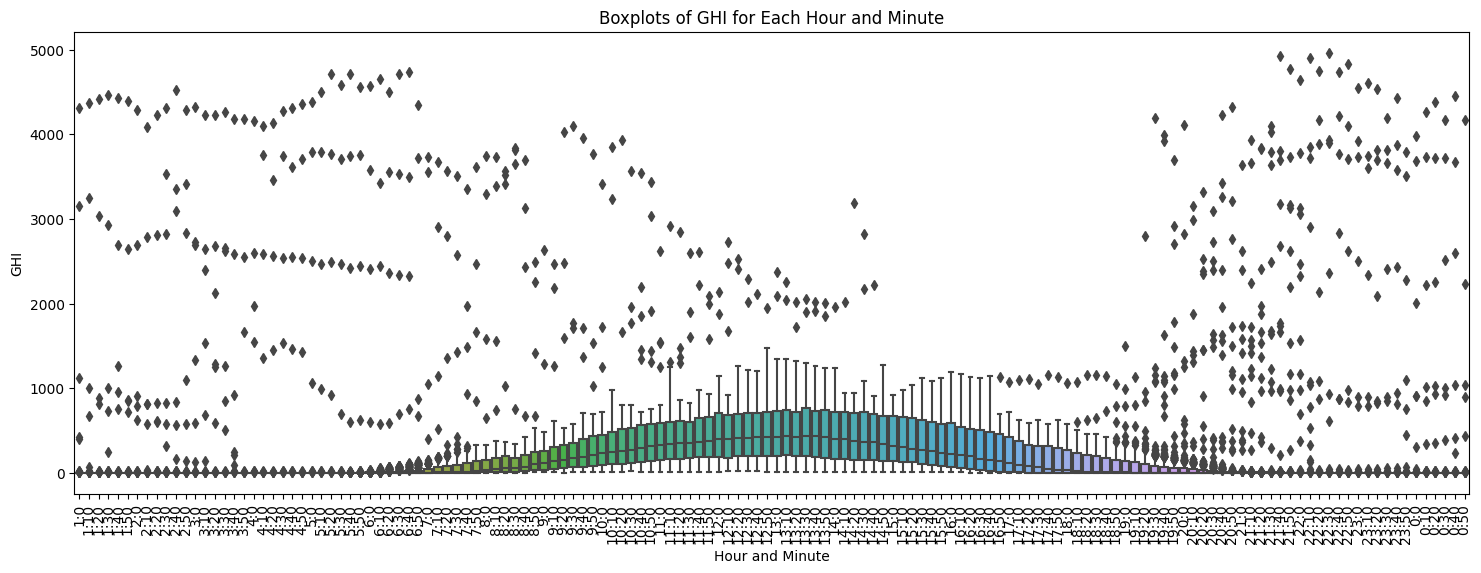

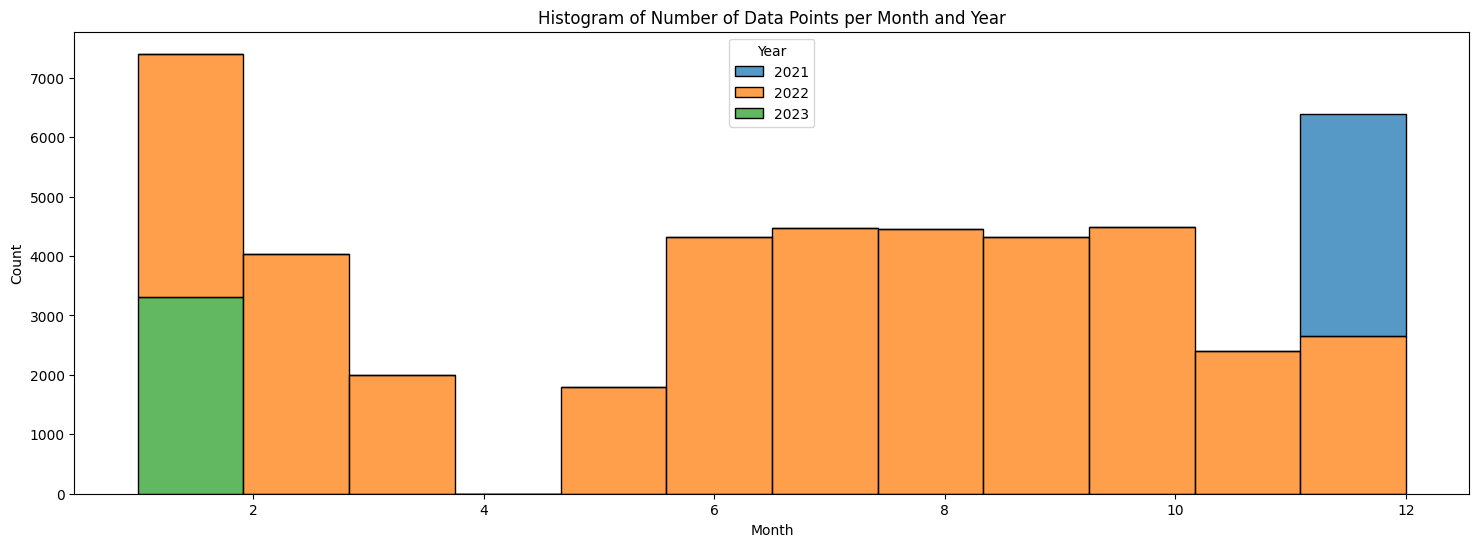

In [ ]:
plot_ghi_data_distribution(ghi_dataset)

Let's visualise the GHI values in boxplots according to the time they were recorded.

Let's make a summary excel sheet with the median, Q1 and Q2 of all the time stamps. This will allow us to adjust for outliers.

In [ ]:
output_path = os.path.join(path, 'median_Q1_Q3.xlsx')
summary_df = create_ghi_summary(training_set,output_path)

Hour       10.0
Minute      0.0
Median    405.0
Q1        181.5
Q3        694.5
Name: 60, dtype: float64


As can be seen on the graph above, there are many wrong values. Indeed the GHI values in Switzerland usually do not exceed 1000 (even 800 is high for this country). Furthermore, according to https://www.donneesmondiales.com/europe/suisse/coucher-soleil.php we can safely assume that values between 11PM and 5AM should be zero